In [1]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import GridSearchCV, validation_curve, StratifiedKFold
from sklearn.svm import SVC
import numpy as np 
%matplotlib inline

#### Load porosity and permeability data

From Douglas Cant and Valerie Ethier (1984). 
Lithology-Dependent Diagenetic Control of Reservoir Properties of Conglomerates, Falher Member, Elmworth Field, Alberta. AAPG Bulletin, 68 (8), pages 1044-1054.  Data accessed through [USGS Open-file Report 03-420A](https://pubs.usgs.gov/of/2003/ofr-03-420/ofr-03-420.html): Catalogue of Porosity and Permeability from Core Plugs in Siliciclastic Rocks.

In [2]:
data = np.loadtxt('9-Cant&Ethier-1994.txt', skiprows = 1, usecols=(0,1,2,3))

#### Split into feature and target variables

In [3]:
X = [[poro, perm] for poro, perm in zip(data[:-1,0], data[:-1,1])]
y = data[:-1,3]

#### Make accuracy scorer for crossvalidation

In [4]:
Ascorer = make_scorer(accuracy_score)

#### Create model with RBF kernel, train with k-fold cv, find optimal parameters

In [5]:
clf = SVC(kernel = 'rbf')

skf = StratifiedKFold(n_splits=12)  # stratified k-fold ensures balanced classes
                                    # because there are not a lot of points I want a high cv,
                                    # in this case, n_splits
                                    # (n_splits= 16 would be LOOCV 
                                    # because there are 17 samples in class 2)

C_range = np.array([ 0.1, 0.5, 1, 2, 5, 7, 10, 20, 50, 100, 200, 300, 500])
gamma_range = np.array([0.00001, 0.0001, 0.001, 0.01, 0.1, 1., 10., 100.])


param_grid = dict(gamma=gamma_range, C=C_range)

grid_search = GridSearchCV(clf,
                           param_grid=param_grid,
                           scoring = Ascorer, 
                           n_jobs = -1, cv = skf)
            
grid_search.fit(X, y)

print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

grid_search.best_estimator_


Best score: 0.833333333333
Best parameters: {'C': 5.0, 'gamma': 0.10000000000000001}


SVC(C=5.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.10000000000000001,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

#### Create two models with different parameter C, show the difference between gamma parameter learning curves

##### RBF kernel, default C

[ 0.62777778  0.62777778  0.62777778  0.61666667  0.80138889  0.7125
  0.70972222  0.62777778]
0.801388888889
0.1


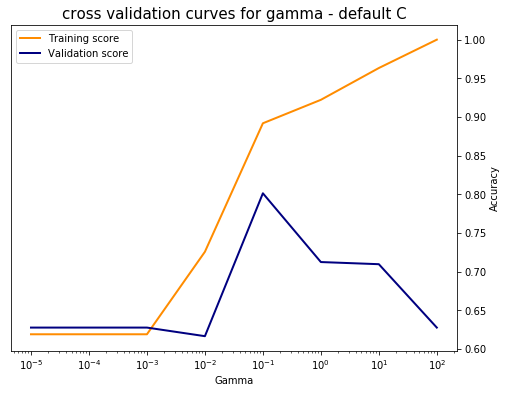

In [6]:
clf_lrn1 = SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

train_scores1, test_scores1 = validation_curve(clf_lrn1, X, y, "gamma", gamma_range, 
                                              cv =skf, 
                                               scoring = Ascorer, n_jobs = -1)

train_scores_mean1 = np.mean(train_scores1, axis=1)
train_scores_std1= np.std(train_scores1, axis=1)
test_scores_mean1 = np.mean(test_scores1, axis=1)
test_scores_std1 = np.std(test_scores1, axis=1)

print test_scores_mean1
print np.amax(test_scores_mean1) # optimal (minimum) average RMS test error
print  gamma_range[test_scores_mean1.argmax(axis=0)] # optimal C parameter value

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

plt.title("cross validation curves for gamma - default C", fontsize = 15)
plt.xlabel("Gamma")
plt.ylabel("Accuracy")
#plt.xlim(0.01, 0.12)
#plt.ylim(0.09, 0.26)
ax.set_xscale('log')
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")

lw = 2

ax = plt.plot(gamma_range, train_scores_mean1, label="Training score", color="darkorange", lw=lw)
ax = plt.plot(gamma_range, test_scores_mean1, label="Validation score", color="navy", lw=lw)

plt.legend(loc="best")

fig.savefig('val_crvs_gamma_default_C.png', dpi=400, bbox_inches='tight', pad_inches=0.4)
plt.show()

##### RBF kernel, optimal C (from cv training above)

[ 0.62777778  0.62777778  0.62777778  0.82222222  0.83888889  0.7125
  0.65416667  0.61111111]
0.838888888889
0.1


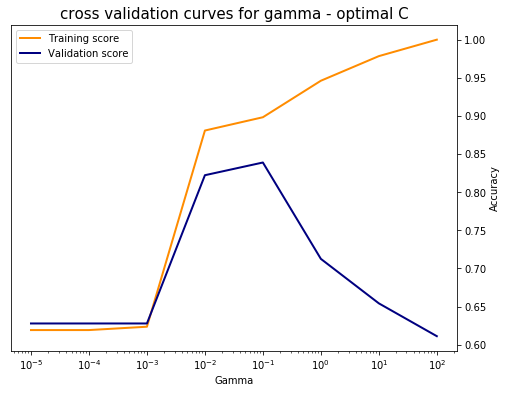

In [7]:
clf_lrn2 = SVC(C=5.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

train_scores2, test_scores2 = validation_curve(clf_lrn2, X, y, "gamma", gamma_range, 
                                              cv =skf, 
                                               scoring = Ascorer, n_jobs = -1)

train_scores_mean2 = np.mean(train_scores2, axis=1)
train_scores_std2= np.std(train_scores2, axis=1)
test_scores_mean2 = np.mean(test_scores2, axis=1)
test_scores_std2 = np.std(test_scores2, axis=1)

print test_scores_mean2
print np.amax(test_scores_mean2) # optimal (minimum) average RMS test error
print gamma_range[test_scores_mean2.argmax(axis=0)] # optimal Gamma parameter value

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

plt.title("cross validation curves for gamma - optimal C", fontsize = 15)
plt.xlabel("Gamma")
plt.ylabel("Accuracy")
#plt.xlim(0.01, 0.12)
#plt.ylim(0.09, 0.26)
ax.set_xscale('log')
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")

lw = 2

ax = plt.plot(gamma_range, train_scores_mean2, label="Training score", color="darkorange", lw=lw)
ax = plt.plot(gamma_range, test_scores_mean2, label="Validation score", color="navy", lw=lw)

plt.legend(loc="best")

fig.savefig('val_crvs_gamma_optimal_C.png', dpi=400, bbox_inches='tight', pad_inches=0.4)
plt.show()